In [1]:
from google import genai
from google.genai import types
import os
from PIL import Image
from io import BytesIO
import base64
import IPython
import textwrap
import time

In [2]:
client = genai.Client(api_key=os.environ.get("GOOGLE_API_KEY"))
# Listing avaialble models
for model in client.models.list():
        print(model.name)

models/embedding-gecko-001
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/learnlm-2.0-flash-experimental
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-

In [3]:
MODEL_ID = "gemini-robotics-er-1.5-preview"

print(client.models.generate_content(model=MODEL_ID, contents="Are you there?").text)

Yes, I am here. How can I help you today?


In [4]:
# Helper functions

# JSON parsing and UI display helpers

def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            # Remove everything before "```json"
            json_output = "\n".join(lines[i + 1 :])
            # Remove everything after closing "```"
            json_output = json_output.split("```")[0]
            break # Exit the loop once "```json" is found
    return json_output

def generate_point_html(pil_image, points_json):
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    points_json = parse_json(points_json)

    return f"""
<!DOCTYPE html>
<html>
<head>
    <title>Point Visualization</title>
    <style>
        html, body {{
            margin: 0;
            padding: 0;
            background: transparent;
            color: #fff;
            font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, sans-serif;
        }}

        #container {{
            background: transparent;
        }}

        .point-overlay {{
            position: absolute;
            top: 0;
            left: 0;
            width: 100%;
            height: 100%;
            pointer-events: none;
        }}

        .point {{
            position: absolute;
            width: 12px;
            height: 12px;
            background-color: #2962FF;
            border: 2px solid #fff;
            border-radius: 50%;
            transform: translate(-50%, -50%);
            box-shadow: 0 0 40px rgba(41, 98, 255, 0.6);
            opacity: 0;
            transition: all 0.3s ease-in;
            pointer-events: auto;
        }}

        .point.visible {{
            opacity: 1;
        }}

        .point.fade-out {{
            animation: pointFadeOut 0.3s forwards;
        }}

        .point.highlight {{
            transform: translate(-50%, -50%) scale(1.1);
            background-color: #FF4081;
            box-shadow: 0 0 40px rgba(255, 64, 129, 0.6);
            z-index: 100;
        }}

        @keyframes pointFadeOut {{
            from {{
                opacity: 1;
            }}
            to {{
                opacity: 0.7;
            }}
        }}

        .point-label {{
            position: absolute;
            background-color: #2962FF;
            color: #fff;
            font-size: 14px;
            padding: 4px 12px;
            border-radius: 4px;
            transform: translate(20px, -10px);
            white-space: nowrap;
            opacity: 0;
            transition: all 0.3s ease-in;
            box-shadow: 0 0 30px rgba(41, 98, 255, 0.4);
            pointer-events: auto;
            cursor: pointer;
        }}

        .point-label.visible {{
            opacity: 1;
        }}

        .point-label.fade-out {{
            opacity: 0.45;
        }}

        .point-label.highlight {{
            background-color: #FF4081;
            box-shadow: 0 0 30px rgba(255, 64, 129, 0.4);
            transform: translate(20px, -10px) scale(1.1);
            z-index: 100;
        }}
    </style>
</head>
<body>
    <div id="container" style="position: relative;">
        <canvas id="canvas" style="display: block;"></canvas>
        <div id="pointOverlay" class="point-overlay"></div>
    </div>

    <script>
        function annotatePoints(frame) {{
            // Add points with fade effect
            const pointsData = {points_json};

            const pointOverlay = document.getElementById("pointOverlay");
            pointOverlay.innerHTML = "";

            const points = [];
            const labels = [];

            pointsData.forEach(pointData => {{
                // Skip entries without coodinates.
                if (!(pointData.hasOwnProperty("point")))
                  return;

                const point = document.createElement("div");
                point.className = "point";
                const [y, x] = pointData.point;
                point.style.left = `${{x/1000.0 * 100.0}}%`;
                point.style.top = `${{y/1000.0 * 100.0}}%`;

                const pointLabel = document.createElement("div");
                pointLabel.className = "point-label";
                pointLabel.textContent = pointData.label;
                point.appendChild(pointLabel);

                pointOverlay.appendChild(point);
                points.push(point);
                labels.push(pointLabel);

                setTimeout(() => {{
                    point.classList.add("visible");
                    pointLabel.classList.add("visible");
                }}, 0);

                // Add hover effects
                const handleMouseEnter = () => {{
                    // Highlight current point and label
                    point.classList.add("highlight");
                    pointLabel.classList.add("highlight");

                    // Fade out other points and labels
                    points.forEach((p, idx) => {{
                        if (p !== point) {{
                            p.classList.add("fade-out");
                            labels[idx].classList.add("fade-out");
                        }}
                    }});
                }};

                const handleMouseLeave = () => {{
                    // Remove highlight from current point and label
                    point.classList.remove("highlight");
                    pointLabel.classList.remove("highlight");

                    // Restore other points and labels
                    points.forEach((p, idx) => {{
                        p.classList.remove("fade-out");
                        labels[idx].classList.remove("fade-out");
                    }});
                }};

                point.addEventListener("mouseenter", handleMouseEnter);
                point.addEventListener("mouseleave", handleMouseLeave);
                pointLabel.addEventListener("mouseenter", handleMouseEnter);
                pointLabel.addEventListener("mouseleave", handleMouseLeave);
            }});
        }}

        // Initialize canvas
        const canvas = document.getElementById("canvas");
        const ctx = canvas.getContext("2d");
        const container = document.getElementById("container");

        // Load and draw the image
        const img = new Image();
        img.onload = () => {{
            const aspectRatio = img.height / img.width;
            canvas.width = 800;
            canvas.height = Math.round(800 * aspectRatio);
            container.style.width = canvas.width + "px";
            container.style.height = canvas.height + "px";

            ctx.drawImage(img, 0, 0, canvas.width, canvas.height);

            frame.width = canvas.width;
            frame.height = canvas.height;
            annotatePoints(frame);
        }};
        img.src = "data:image/png;base64,{img_str}";

        const frame = {{
            width: canvas.width,
            height: canvas.height
        }};

        annotatePoints(frame);
    </script>
</body>
</html>
"""


Many of the example use the same recipe - an image, a prompt, and a `GenerateContentConfig`. These functions will help reduce code duplication.

In [5]:
# Resizing to speed-up rendering
def get_img_resized(img_path):
    img = Image.open(img_path)
    img = img.resize((800, int(800 * img.size[1] / img.size[0])), Image.Resampling.LANCZOS) # resize keeps width at 800, preserves aspect ratio, and uses the Lanczos filter for quality
    return img

def call_gemini_robotics_er(img, prompt, config=None):
    if config is None:
        config = types.GenerateContentConfig(
            temperature=0.5,
            thinking_config=types.ThinkingConfig(thinking_budget=0)
        )

    image_response = client.models.generate_content(
        model=MODEL_ID,
        contents=[img, prompt],
        config=config
    )

    print(image_response.text) # Debug print
    return parse_json(image_response.text)
    

### Pointing to Undefined Objects

In [6]:
img = get_img_resized("test_images/aloha-arms-table.png")
prompt = textwrap.dedent("""\
    Point to no more than 10 items in the image. The label returned should be an 
    identifying name for the object detected.

    The answer should follow the JSON format:
    [{"point": <point>, "label": <label1>}, ...]

    The points are in [y, x] format normalized to 0-1000.""")

In [7]:
start_time = time.time()
json_output = call_gemini_robotics_er(img, prompt)
end_time = time.time()
print(f"Time taken: {(end_time - start_time):.4f} seconds")



```json
[
  {"point": [379, 70], "label": "robot arm"},
  {"point": [379, 881], "label": "robot arm"},
  {"point": [372, 608], "label": "paper bag"},
  {"point": [267, 401], "label": "bowl"},
  {"point": [372, 301], "label": "bag of nuts"},
  {"point": [506, 362], "label": "toy tomato"},
  {"point": [619, 452], "label": "measuring cup"},
  {"point": [629, 310], "label": "slice of bread"},
  {"point": [837, 792], "label": "slice of bread"},
  {"point": [629, 672], "label": "toy banana"}
]
```
Time taken: 2.6199 seconds



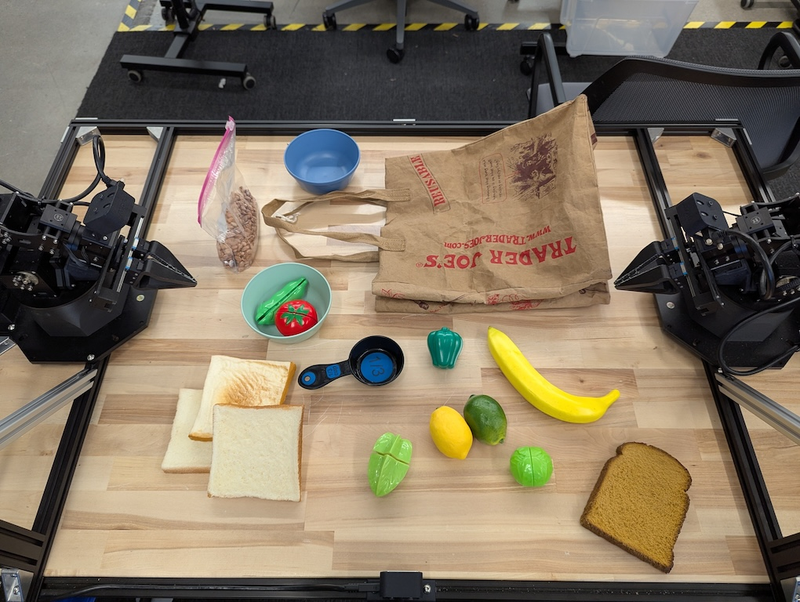

In [8]:
IPython.display.HTML(generate_point_html(img, json_output))